# Train independent model on prepandemic sequences

In [7]:
import os, sys
pgm_path = 'PGM/'
sys.path.append(pgm_path + 'source/')
sys.path.append(pgm_path + 'utilities/')
from global_variables import *

import rbm, RBM_utils
import utilities, Proteins_utils, sequence_logo, plots_utils 

import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score

%matplotlib inline

In [3]:

path = 'seq_data/'
filename = 'rbd_aligned_sequences.fasta'

In [4]:
sequences = Proteins_utils.load_FASTA(path + filename) # Load protein sequences.
print('shape of sequences:', np.shape(sequences))
print('sequences:', sequences)

shape of sequences: (2240, 178)
sequences: [[15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 ...
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]]
shape of sequences: (2240, 178)
sequences: [[15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 ...
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]]
shape of sequences: (2240, 178)


In [5]:
perm = np.arange(sequences.shape[0])
#fix seed
np.random.seed(0)
np.random.shuffle(perm)

len_validation = sequences.shape[0] // 100
train_sequences=sequences[perm[:-len_validation]]
validation_sequences=sequences[perm[-len_validation:]]
rand_data = np.random.randint(low=0, high=20, size=train_sequences.shape, dtype=np.int16)

print('Train sequences shape:', train_sequences.shape)
print('Validation sequences shape:', validation_sequences.shape)
print('Random data shape:', rand_data.shape)

#unfix seed
np.random.seed(None)


Train sequences shape: (2218, 178)
Validation sequences shape: (22, 178)
Random data shape: (2218, 178)


In [6]:

def calculate_weighted_amino_acid_probabilities(encoded_sequences, sequence_weights):
    # Assuming encoded_sequences is a 2D numpy array of size N*L
    # and sequence_weights is a 1D numpy array of size N
    N, L = encoded_sequences.shape
    num_amino_acids = 21  # Including 0 to 20 encoding

    # Initialize an array to store probabilities for each position and amino acid
    probabilities = np.zeros((L, num_amino_acids))

    # Calculate probabilities for each position
    for position in range(L):
        # Count weighted occurrences of each amino acid at the current position
        amino_acid_counts = np.bincount(encoded_sequences[:, position],
                                        weights=sequence_weights,
                                        minlength=num_amino_acids)

        # Calculate probabilities for each amino acid
        probabilities[position] = amino_acid_counts / np.sum(sequence_weights)

    return probabilities


In [8]:
class IndepModel:
    def __init__(self, num_amino_acids=21):
        self.num_amino_acids = num_amino_acids
        self.proba = None

    def fit(self, sequences, weights):
        # sequences: 2D array of size N*L
        # weights: 1D array of size N

        N, L = sequences.shape
        print ('N:', N, 'L:', L)
        self.proba = np.zeros((L, self.num_amino_acids))

        for position in range(L):
            amino_acid_counts = np.bincount(sequences[:, position],
                                            weights=weights,
                                            minlength=self.num_amino_acids)

            self.proba[position] = amino_acid_counts / np.sum(weights)
       

    def likelihood_unique(self, encoded_sequence):
        encoded_sequence = np.array(encoded_sequence)
        # encoded_sequence: 1D array of size L
        if self.proba is None:
            raise ValueError("Model not fitted. Call fit() first.")
        log_prob_sequence = np.log(self.proba[np.arange(encoded_sequence.size), encoded_sequence])
        log_prob_sequence[log_prob_sequence == -np.inf] = -10
        return np.sum(log_prob_sequence)

    def likelihood(self, encoded_sequences):
        #if one dimensional
        if len(encoded_sequences.shape) == 1:
            return self.likelihood_unique(encoded_sequences)

        # encoded_sequences: 2D array of size N*L
        if self.proba is None:
            raise ValueError("Model not fitted. Call fit() first.")

        return np.array([self.likelihood_unique(encoded_sequence) for encoded_sequence in encoded_sequences])
    def entropy(self, epsilon=1e-15, beta=1):
        if self.proba is None:
            raise ValueError("Model not fitted. Call fit() first.")
        probas=self.proba
        #for each position, put all proba to the power beta and normalize
        probas = probas**beta
        probas = probas / np.sum(probas, axis=1)[:, np.newaxis]
        # Calculate entropy at each position
        position_entropies = -np.sum(probas * np.log(probas + epsilon), axis=1)  # 1e-15 to avoid log(0)
        print('position_entropies:', position_entropies.shape)
        total_entropy = np.sum(position_entropies)
        return total_entropy
    


N: 2218 L: 178


C:\Users\maria\AppData\Local\Temp\ipykernel_10056\3472018945.py:27: RuntimeWarning: divide by zero encountered in log
  log_prob_sequence = np.log(self.proba[np.arange(encoded_sequence.size), encoded_sequence])


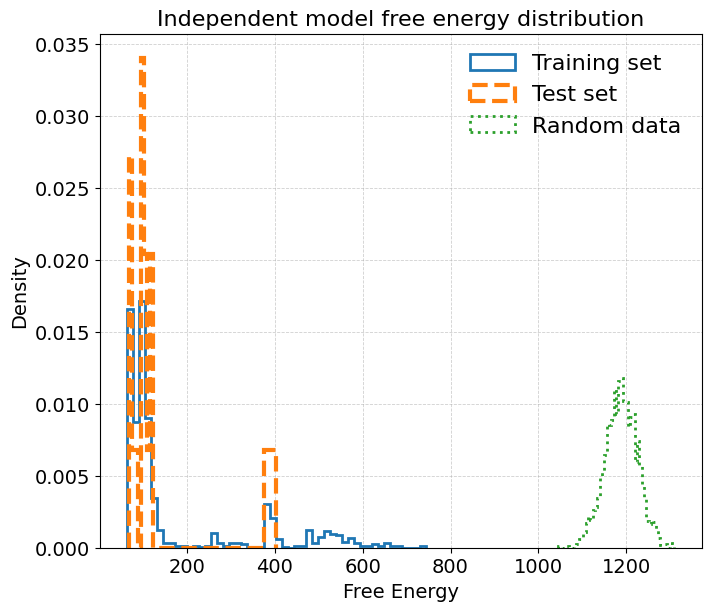

In [9]:
indep_model = IndepModel()
sequence_weights = np.ones(train_sequences.shape[0])

indep_model.fit(train_sequences, sequence_weights)


# Create the figure
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

# Plot histogram with enhanced visibility
ax.hist(-indep_model.likelihood(train_sequences), bins=50, density=True, histtype='step', lw=2, fill=False, label="Training set")
ax.hist(-indep_model.likelihood(validation_sequences), bins=50, density=True, histtype='step', lw=3, fill=False, label="Test set", linestyle='--')
ax.hist(-indep_model.likelihood(rand_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Random data", linestyle=':')


# Enhancing aesthetics
ax.set_xlabel("Free Energy", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title("Independent model free energy distribution", fontsize=16)



# Customizing legend
ax.legend(fontsize=16, loc='upper right', frameon=False)

# Customizing ticks and grid
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)


# Display the plot
plt.show()





# Adding exp data

In [10]:
WT_embe=Proteins_utils.load_FASTA('seq_data/rbd_wt.fasta')
WT_embe = [seq[BEGIN:-END] for seq in WT_embe]
WT_embe=np.array(WT_embe)
likelihood_WT = indep_model.likelihood(WT_embe)
print('likelihood_WT:', likelihood_WT)


likelihood_WT: [-528.53486632]


C:\Users\maria\AppData\Local\Temp\ipykernel_10056\3472018945.py:27: RuntimeWarning: divide by zero encountered in log
  log_prob_sequence = np.log(self.proba[np.arange(encoded_sequence.size), encoded_sequence])


In [ ]:
df_bloom=pd.read_csv('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.csv')
df_bloom=df_bloom[df_bloom['site_SARS2']>=349] 
df_bloom=df_bloom[df_bloom['site_SARS2']<=526]
df_bloom=df_bloom.reset_index(drop=True)
#sequence column to fasta file
with open('exp_data/bloom_deep_scan_ACE2_with_sequence.fasta', 'w') as f:
    for index, row in df_bloom.iterrows():
        #if * in sequence, remove sequence
        if '*' in row['sequence']:
            continue
        f.write('>' + str(index) + '\n')
        f.write(row['sequence'] + '\n')


In [12]:
bloom_sequences=Proteins_utils.load_FASTA('exp_data/bloom_deep_scan_ACE2_with_sequence.fasta')
print('shape of sequences:', np.shape(bloom_sequences))
bloom_sequences = [seq[BEGIN:-END] for seq in bloom_sequences]
bloom_sequences=np.array(bloom_sequences)
bloom_sequences.shape

shape of sequences: (3327, 201)


(3327, 178)

In [13]:

#for each sequence in df_bloom, compute likelihood
sequences_likelihood = indep_model.likelihood(bloom_sequences)
df_bloom['likelihood'] = sequences_likelihood
sequences_likelihood

C:\Users\maria\AppData\Local\Temp\ipykernel_10056\3472018945.py:27: RuntimeWarning: divide by zero encountered in log
  log_prob_sequence = np.log(self.proba[np.arange(encoded_sequence.size), encoded_sequence])


array([-533.33478058, -536.32356659, -534.02792776, ..., -525.50525502,
       -532.14578423, -535.13457024])

In [14]:
df_bloom['deltaE'] = df_bloom['likelihood']-likelihood_WT
df_bloom_avg = df_bloom.groupby('site_SARS2').agg(lambda x: x.mean() if np.issubdtype(x.dtype, np.number) else x.iloc[0]).reset_index()

df_bloom_avg

,site_SARS2,site_RBD,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence,likelihood,deltaE
0,349,19.0,S,A,S349A,S19A,-1.153684,-1.152105,-1.152105,-1.941053,-1.807895,-1.875263,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...,-534.152050,-5.617183
1,350,20.0,V,A,V350A,V20A,-2.873333,-2.721667,-2.798889,-2.285000,-2.210000,-2.247222,NITNLCPFGEVFNATRFASAYAWNRKRISNCVADYSVLYNSASFST...,-535.261395,-6.726529
2,351,21.0,Y,A,Y351A,Y21A,-1.035789,-1.073158,-1.055263,-1.898421,-1.785789,-1.842632,NITNLCPFGEVFNATRFASVAAWNRKRISNCVADYSVLYNSASFST...,-534.056076,-5.521210
3,352,22.0,A,C,A352C,A22C,-0.310000,-0.360526,-0.335263,-0.957368,-0.898421,-0.927368,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,-532.999029,-4.464163
4,353,23.0,W,A,W353A,W23A,-1.598421,-1.606842,-1.603684,-2.225263,-2.206842,-2.214211,NITNLCPFGEVFNATRFASVYAANRKRISNCVADYSVLYNSASFST...,-535.410452,-6.875586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,522,192.0,A,C,A522C,A192C,-0.003158,-0.018947,-0.011053,-0.051579,-0.177895,-0.115263,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-532.511321,-3.976455
174,523,193.0,T,A,T523A,T193A,-0.018333,-0.036667,-0.028333,-0.258333,-1.110000,-0.686667,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-532.194728,-3.659861
175,524,194.0,V,A,V524A,V194A,-0.552000,-0.034000,-0.294000,0.026000,-0.636000,-0.306000,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-534.893285,-6.358419
176,525,195.0,C,A,C525A,C195A,-0.203889,-0.095556,-0.150000,-0.352222,-0.620000,-0.487778,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-532.461544,-3.926678


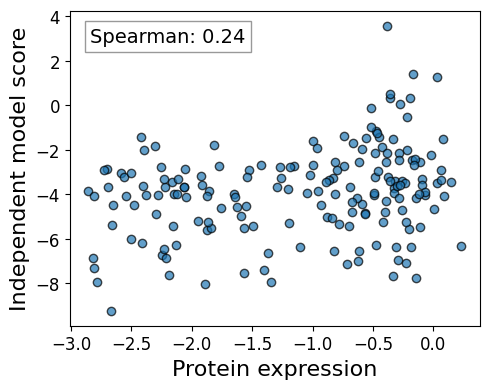

(0.23605080809295173, 0.0015135580772667316, -13.530189829494997)

In [15]:


# Data
x = df_bloom_avg['expr_avg']
y = df_bloom_avg['deltaE']

# Metrics
spearman_corr, spearman_pval = stats.spearmanr(x, y)
r2 = r2_score(x, y)

# Plot
plt.figure(figsize=(5, 4))
plt.scatter(x, y, color='#1f77b4', alpha=0.7, edgecolor='black')

plt.xlabel('Protein expression', fontsize=16)
plt.ylabel('Independent model score', fontsize=16)

# Stats box
plt.text(
    0.05, 0.95, f"Spearman: {spearman_corr:.2f}",
    transform=plt.gca().transAxes, fontsize=14, va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey')
)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Clean look
ax = plt.gca()


plt.tight_layout()
plt.show()

spearman_corr, spearman_pval, r2
